In [497]:
import itertools
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles, make_moons

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [498]:
def plot(data):
    colormap = {0: 'red', 1: 'green'}
    colors = [colormap[x] for x in data['class']]

    p = figure(
        plot_width=400,
        plot_height=400)
    p.xaxis.axis_label = 'x₁'
    p.yaxis.axis_label = 'x₂'
    p.circle(data['x2'], data['x1'], color=colors, fill_alpha=0.2, size=6)
    return p

In [499]:
size = 1000
means = np.array([[[0, 1], [1, 0]], [[0.5, 1.5], [1, 0]]])
covs = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]]])
means = means / 2
covs = covs / 50
datas = []
for mean, cov in zip(means, covs):
    pos_mean, neg_mean = mean
    pos_dist = stats.multivariate_normal(pos_mean, cov)
    neg_dist = stats.multivariate_normal(neg_mean, cov)
    x_pos = pos_dist.rvs(size // 2)
    y_pos = np.ones(size // 2)
    x_neg = neg_dist.rvs(size // 2)
    y_neg = np.zeros(size // 2)
    x = np.concatenate((x_pos, x_neg), axis=0)
    y = np.concatenate((y_pos, y_neg)).reshape((-1, 1))
    data = np.concatenate((x, y), axis=1)
    data = pd.DataFrame(data, columns=['x1', 'x2', 'class'])
    datas.append(data)

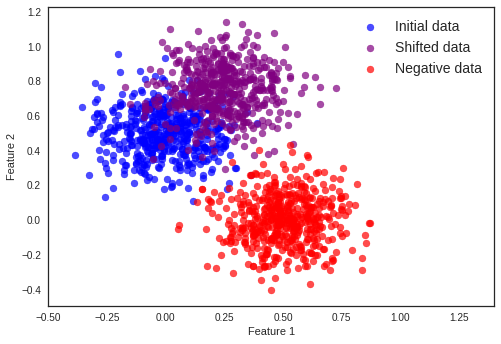

In [500]:
#ax = datas[0].sample(frac=1).plot.scatter(x='x1', y='x2', c='class', colormap='RdPu', colorbar=False, alpha = 1,label='Original data')
#datas[1].sample(frac=1).plot.scatter(x='x1', y='x2', c='class', colormap='RdBu', colorbar=False, ax=ax, alpha = 1,label='Shifted data')
#plt.legend(fontsize=14, markerscale=2, framealpha=1)
#plt.savefig('plots/data.png')
pos1 = datas[0][datas[0]['class']==1]
pos2 = datas[1][datas[1]['class']==1]
neg = datas[0][datas[0]['class']==0]
plt.scatter(pos1.x1, pos1.x2, color='blue', alpha=0.7, label='Initial data')
plt.scatter(pos2.x1, pos2.x2, color='purple', alpha=0.7, label='Shifted data')
plt.scatter(neg.x1, neg.x2, color='red', alpha=0.7, label='Negative data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim([-0.5, 1.4])
plt.xlim([-0.5, 1.4])
plt.legend(fontsize=14)
plt.savefig('plots/data.pdf')

In [501]:
# Init
ds = datas[0]
X = StandardScaler().fit_transform(ds[['x1', 'x2']])
y = ds[['class']].values.ravel()

In [502]:
# Ins1
ds = datas[1]
X1 = StandardScaler().fit_transform(ds[['x1', 'x2']])
y1 = ds[['class']].values.ravel()

In [503]:
# Ins2
ds = datas[2]
X2 = StandardScaler().fit_transform(ds[['x1', 'x2']])
y2 = ds[['class']].values.ravel()

IndexError: list index out of range

In [504]:
import sys
sys.path.append('../facebook/bloom_classifier')
import bloom_classifier as bc

# Baseline

In [505]:
# Plain Bloom filter
import bloom_filter as bf
my_bf = bf.BloomFilter(p=0.01, n=1000)
for x_, y_ in zip(X, y):
    if y_:
        my_bf.insert(x_)

fp = len([x_ for x_, y_ in zip(X, y) if my_bf.check(x_) and y_ == 0])
n = len([y_ for y_ in y if y_ == 0])
init_fpr1_basic = fp / n

for x_, y_ in zip(X1, y1):
    if y_:
        my_bf.insert(x_)
    
fp = len([x_ for x_, y_ in zip(X1, y1) if my_bf.check(x_) and y_ == 0])
n = len([y_ for y_ in y if y_ == 0])
insert_fpr1_basic = fp / n
print(init_fpr1_basic)
print(insert_fpr1_basic)

0.006
0.01


In [506]:
# Plain Bloom filter
import bloom_filter as bf
my_bf2 = bf.BloomFilter(p=0.01, n=1000)
for x_, y_ in zip(X, y):
    if y_:
        my_bf2.insert(x_)

fp = len([x_ for x_, y_ in zip(X, y) if my_bf2.check(x_) and y_ == 0])
n = len([y_ for y_ in y if y_ == 0])
init_fpr2_basic = fp / n

for x_, y_ in zip(X2, y2):
    if y_:
        my_bf2.insert(x_)
    
fp = len([x_ for x_, y_ in zip(X, y) if my_bf2.check(x_) and y_ == 0])
n = len([y_ for y_ in y if y_ == 0])
insert_fpr2_basic = fp / n
print(init_fpr2_basic)
print(insert_fpr2_basic)

0.006
0.024


In [507]:
model = MLPClassifier(hidden_layer_sizes=(10, 10, 5))
model.fit(X, y)

my_bc1 = bc.BloomClassifier(model)
my_bc1.initialize(X, y, m=5000)
init1_fpr = my_bc1.get_fpr(X, y)
my_bc1.add_data(X1, y1, model)
ins1_fpr = my_bc1.get_fpr(X1, y1)
print(init1_fpr)
print(ins1_fpr)

my_bc2 = bc.BloomClassifier(model)
my_bc2.initialize(X, y, m=5000)
init2_fpr = my_bc2.get_fpr(X, y)
my_bc2.add_data(X2, y2, model)
ins2_fpr = my_bc1.get_fpr(X2, y2)
print(init2_fpr)
print(ins2_fpr)

/home/arindam/anaconda3/envs/work36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.008
0.022
0.008
0.008


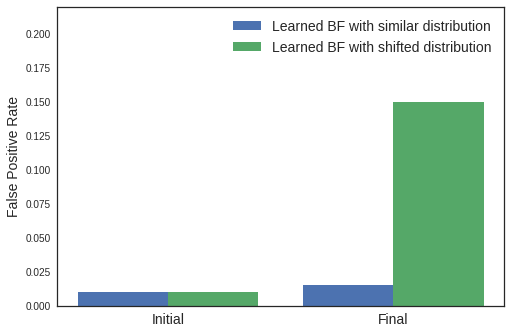

In [508]:
x_axis = np.array([0.3, 0.6])
width = 0.12
plt.bar(x_axis - 0.5*width, [0.01, 0.015], width=width, label='Learned BF with similar distribution')
plt.bar(x_axis + 0.5*width, [0.01, 0.15], width=width, label='Learned BF with shifted distribution')
plt.xticks([0.3, 0.6], ['Initial', 'Final'], fontsize=14)
plt.ylim([0, 0.22])
plt.ylabel('False Positive Rate', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('plots/baseline_dynamic.pdf')

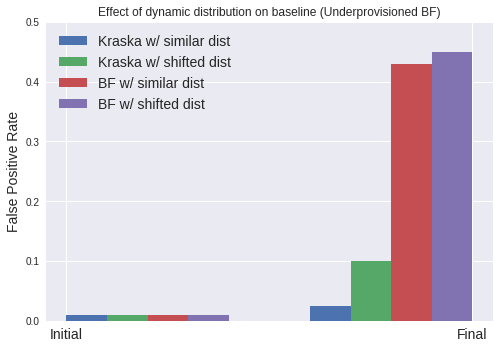

In [445]:
x_axis = np.array([0.2, 0.8])
width = 0.1
plt.bar(x_axis - 1.5*width, [0.01, 0.025], width=width, label='Kraska w/ similar dist')
plt.bar(x_axis - 0.5*width, [0.01, 0.1], width=width, label='Kraska w/ shifted dist')
plt.bar(x_axis + 0.5*width, [0.01, 0.43], width=width, label='BF w/ similar dist')
plt.bar(x_axis + 1.5*width, [0.01, 0.45], width=width, label='BF w/ shifted dist')
plt.xticks([0, 1], ['Initial', 'Final'], fontsize=14)
plt.ylim([0, 0.5])
plt.ylabel('False Positive Rate', fontsize=14)
plt.legend(fontsize=14)
plt.title('Effect of dynamic distribution on baseline (Underprovisioned BF)')
plt.savefig('plots/baseline_dynamic_under.png')

# IA-LBF

In [349]:
model = MLPClassifier(hidden_layer_sizes=(10, 10, 5))
model.fit(X, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [350]:
import sys
sys.path.append('../facebook/dpbf_classifier/')
import dpbf_classification as dc

0.018
0.0172
0.018
0.0146


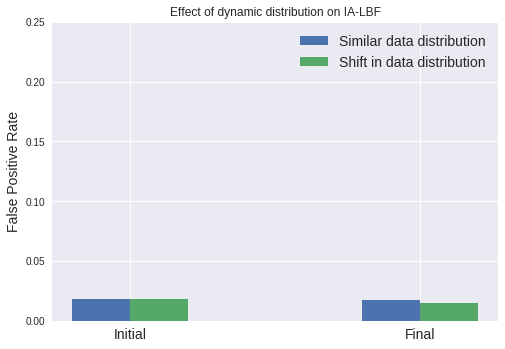

In [351]:
my_dc1 = dc.dpbf_logistic(model)
my_dc1.initialize(X, y, p=0.01)
init1_fpr = my_dc1.get_fpr(X, y)
for x_, y_ in zip(X1, y1):
    if y_:
        my_dc1.insert(x_)
ins1_fpr = my_dc1.get_fpr(X1, y1)
print(init1_fpr)
print(ins1_fpr)

my_dc2 = dc.dpbf_logistic(model)
my_dc2.initialize(X, y)
init2_fpr = my_dc2.get_fpr(X, y)
for x_, y_ in zip(X2, y2):
    if y_:
        my_dc2.insert(x_)
ins2_fpr = my_dc2.get_fpr(X2, y2)
print(init2_fpr)
print(ins2_fpr)

x_axis = np.array([0, 1])
width = 0.2
plt.bar(x_axis - width/2, [init1_fpr, ins1_fpr], width=width, label='Similar data distribution')
plt.bar(x_axis + width/2, [init2_fpr, ins2_fpr], width=width, label='Shift in data distribution')
plt.xticks([0, 1], ['Initial', 'Final'], fontsize=14)
plt.ylim([0, 0.25])
plt.ylabel('False Positive Rate', fontsize=14)
plt.legend(fontsize=14)
plt.title('Effect of dynamic distribution on IA-LBF')
plt.savefig('plots/ialbf_dynamic.png')

# CA-LBF I

0.005
0.006
0.0052
0.0068


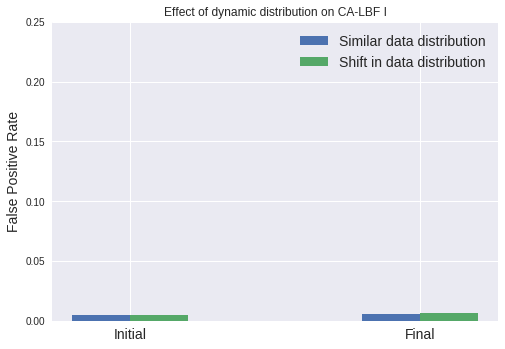

In [352]:
model = MLPClassifier(hidden_layer_sizes=(10, 10, 5), warm_start=True)
model.fit(X, y)
my_bc1 = bc.BloomClassifier(model)
my_bc1.initialize(X, y, m=50000)
init1_fpr = my_bc1.get_fpr(X, y)
model.fit(X1, y1)
my_bc1.add_data(X1, y1, model)
ins1_fpr = my_bc1.get_fpr(X1, y1)
print(init1_fpr)
print(ins1_fpr)

model = MLPClassifier(hidden_layer_sizes=(10, 10, 5), warm_start=True)
model.fit(X, y)
my_bc2 = bc.BloomClassifier(model)
my_bc2.initialize(X, y, m=50000)
init2_fpr = my_bc2.get_fpr(X, y)
model.fit(X2, y2)
my_bc2.add_data(X2, y2, model)
ins2_fpr = my_bc2.get_fpr(X2, y2)
print(init2_fpr)
print(ins2_fpr)

x_axis = np.array([0, 1])
width = 0.2
plt.bar(x_axis - width/2, [init1_fpr, ins1_fpr], width=width, label='Similar data distribution')
plt.bar(x_axis + width/2, [init2_fpr, ins2_fpr], width=width, label='Shift in data distribution')
plt.xticks([0, 1], ['Initial', 'Final'], fontsize=14)
plt.ylim([0, 0.25])
plt.ylabel('False Positive Rate', fontsize=14)
plt.legend(fontsize=14)
plt.title('Effect of dynamic distribution on CA-LBF I')
plt.savefig('plots/calbf1_dynamic.png')

# CA-LBF II

/home/arindam/anaconda3/envs/work36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0052
0.0062


/home/arindam/anaconda3/envs/work36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.005
0.006


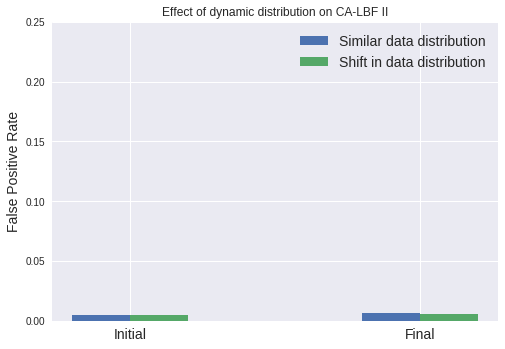

In [353]:
model = MLPClassifier(hidden_layer_sizes=(10, 10, 5), warm_start=False)
model.fit(X, y)
my_bc1 = bc.BloomClassifier(model)
my_bc1.initialize(X, y, m=50000)
init1_fpr = my_bc1.get_fpr(X, y)
model.fit(X1, y1)
my_bc1.add_data(X1, y1, model)
ins1_fpr = my_bc1.get_fpr(X1, y1)
print(init1_fpr)
print(ins1_fpr)

model = MLPClassifier(hidden_layer_sizes=(10, 10, 5), warm_start=False)
model.fit(X, y)
my_bc2 = bc.BloomClassifier(model)
my_bc2.initialize(X, y, m=50000)
init2_fpr = my_bc2.get_fpr(X, y)
model.fit(X2, y2)
my_bc2.add_data(X2, y2, model)
ins2_fpr = my_bc2.get_fpr(X2, y2)
print(init2_fpr)
print(ins2_fpr)

x_axis = np.array([0, 1])
width = 0.2
plt.bar(x_axis - width/2, [init1_fpr, ins1_fpr], width=width, label='Similar data distribution')
plt.bar(x_axis + width/2, [init2_fpr, ins2_fpr], width=width, label='Shift in data distribution')
plt.xticks([0, 1], ['Initial', 'Final'], fontsize=14)
plt.ylim([0, 0.25])
plt.ylabel('False Positive Rate', fontsize=14)
plt.legend(fontsize=14)
plt.title('Effect of dynamic distribution on CA-LBF II')
plt.savefig('plots/calbf2_dynamic.png')